In [3]:
%pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 10.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn import tree
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import neighbors, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from matplotlib import cm, colors
import cv2
import warnings
import collections
import pathlib
import scipy.io

In [5]:
# Returns a list of 
def readRawTreeImages():
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770
    endlayer = 187

    paths = pathlib.Path('../OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]

    del paths_sorted

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])

    objects = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)

    for index, object in coorddf.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
    
    objects = objects[(np.arange(len(objects))!=20) & (np.arange(len(objects))!=27)]
    
    return objects

def readRawHouseImages():
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    powderthickness = 80
    endlayer = 225
    
    paths = pathlib.Path('../OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]

    del paths_sorted

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])

    objects = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)

    for index, object in coorddf.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
    
    objects = objects[(np.arange(len(objects))!=20) & (np.arange(len(objects))!=27)]
    
    return objects

def readCSet():
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    endlayer = 225
    
    paths = pathlib.Path('../OT data 80 um/Int-validation-2').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]

    del paths_sorted

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])

    objects = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)

    for index, object in coorddf.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
    
    objects = objects[(np.arange(len(objects))!=20) & (np.arange(len(objects))!=27)]
    
    return objects

def readRawCircles():
    mat = scipy.io.loadmat('../OT data 80 um/ot_int_data.mat', simplify_cells=True)
    # object, layer, y, x
    def sf(obj):
        return obj['id']
    data = mat.sort(key=sf)
    j = 0
    objects = []
    for i in range(len(data)):
        if data[j]['id'] != data[j]['id']:
            objects.append()


# objects är en 4d numpy array
def makeMask(objects, emptyRatio):
    aggregate = np.sum(objects, axis=(0,1))
    limit = np.percentile(aggregate, emptyRatio)
    mask = aggregate >= limit
    return mask

def getLabels(porositythreshold=0.5):
    segmentdf = pd.read_csv('../Segments.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity", "Area"])
    # segmentdf.insert(1, "VED", segmentdf.P * 1000/(segmentdf.S * segmentdf.H * powderthickness))
    segmentdf.drop(segmentdf[(segmentdf.Objectnumber == 28) | (segmentdf.Objectnumber == 21) ].index, inplace=True)
    segmentdf.reset_index(drop=True, inplace=True)
    segmentdf.insert(1, "Label", np.where(segmentdf.Porosity > porositythreshold, 1, 0))
    return np.array(segmentdf.loc[:,"Label"])

def getLabelsB(objectIndex, porositythreshold, startLayer, endLayer):
    edges = [0,150,187,225]
    segmentdf = pd.read_csv('../Segments2.csv', names=["Object", "Objectnumber", "Segment", "P", "S", "H", "Porosity"])
    layers = endLayer - startLayer + 1
    s1l = max(0, (min(edges[1], endLayer) - max(edges[0], startLayer)))
    s2l = max(0, (min(edges[2], endLayer) - max(edges[1], startLayer)))
    s3l = max(0, (min(edges[3], endLayer) - max(edges[2], startLayer)))
    porosityvalues = segmentdf.loc[segmentdf.Objectnumber == objectIndex, "Porosity"].values
    porosity = (porosityvalues[0] * s1l + porosityvalues[1] * s2l + porosityvalues[2] * s3l) / layers
    return 1 if porosity >= porositythreshold else 0

def makeMaskB(objects, emptyRatio):
    # Later, it would be nice to have a more general approach to this
    aggregate = np.sum(objects, axis=(0))
    limit = np.percentile(aggregate, emptyRatio)
    mask = aggregate >= limit
    return mask
    

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, ):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
    scaler = StandardScaler()
    clf = Pipeline([('scaler', scaler), ('classifier', clf)])
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict_proba(Xtest)[:,1]
    return cvs.mean(), metrics.roc_auc_score(Ytest, yfit)

In [64]:
def readCSet():
    objectwidth = 100
    objectheight = 100
    xspacing = 260
    yspacing = 264
    xstart = 235
    ystart = 247
    xend = 2000
    yend = 2000
    endlayer = 225

    paths = pathlib.Path('../OT data 80 um/Int-validation-2').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]
    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    objects = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)
    for index, object in coorddf.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]

    return objects
objs = readCSet()
plt.imshow(objs[0,0])

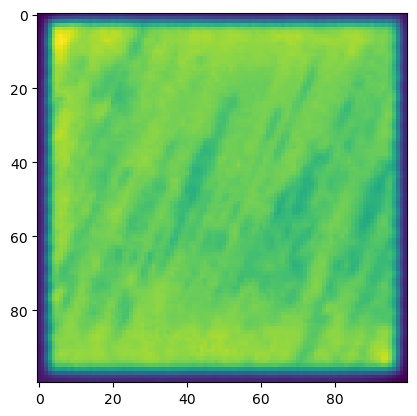

In [66]:
plt.imshow(objs[4,0])

In [ ]:
# Using values from Colosimo's dental protheses case study
# Constants
P_price = 295
V = 6*10**-6
p = 8300
w = 0.05
C_operator = 20
C_pc = 2.5
T_buildprep = 0.5
n_p = 8
C_lpbfsys = 28
C_energy = 0.64
C_inertgas = 5
C_cut = 2
A_baseplate = 0.0625
A_part = 2.5*10**-5
C_measurement = 0.5

# Deterministic parameters
# These values need to be adapted
alpha = 0
beta = 0
y = 0

# Random parameters (not making them random for reproducibility)
CR = 0.5
T_setup = 2
T_build = 7
T_removal = 0.25
T_inspection = 0.5
C_extra = 8

T_proc = T_build
T_pre = T_buildprep + T_setup
T_post = T_removal + T_inspection

# derived values

C_material = P_price * V * p*(1+w)
C_jobprep = (C_operator + C_pc) * T_buildprep / n_p
C_buildprep = C_jobprep
C_setup = (C_operator + C_lpbfsys) * T_setup / n_p
C_pre = C_jobprep + C_setup

# Process cost
C_proc = (C_energy + C_inertgas + C_lpbfsys) * T_build / n_p

# Post processing cost
C_removal = (C_operator + C_lpbfsys) * T_removal / n_p
C_basecut = (C_cut / A_baseplate) * A_part
C_inspection = (C_operator + C_measurement) * T_inspection 
C_post = C_removal + C_basecut + C_inspection

C_scrap = CR * (C_material + C_proc) + C_pre + C_post
C_net = C_material + C_pre + C_proc + C_post
C_part = C_net / (1-y)

def getCost(scrapRatio, fpr, fnr):
    # Recalculate T_build and C_part...
    return 0


In [3]:
class backgroundRemover:
    def __init__(self, mask):
        self.mask = mask
        self.layer = 0

    def removeBackground(self, images):
        rtn = np.copy(images)
        if self.mask.ndim > 2:
            for o in rtn:
                o[~self.mask[self.layer]] = np.nan
            self.layer += 1
        else:
            for o in rtn:
                o[~self.mask] = np.nan
        return rtn
    
class blockAccumulator:
    def __init__(self, windowSize, windowOffset):
        self.ws = windowSize
        self.wo = windowOffset
        self.init = False
        self.currentIndex = 0
        self.data = []

    def reset(self):
        self.init = False
        self.currentIndex = 0
        self.data = []
    
    # Nextlayer är ett lager från varje objekt i en lista
    def next(self, nextLayer):
        for index, objlayer in enumerate(nextLayer):
            if not self.init:
                (x, y) = np.shape(objlayer)
                self.data.append(np.empty((self.ws, x, y)))
            self.data[index][self.currentIndex % self.ws] = objlayer
        self.currentIndex += 1
        self.init = True
        if ((self.currentIndex - self.ws) % self.wo == 0 and self.currentIndex >= self.ws):
            # Returnera de ws senaste lagren, roterat så att senaste lager ligger sist
            return [np.roll(obj, -(self.currentIndex+1 % self.ws), axis=0) for obj in self.data]
        else:
            return False


class accumulator:
    def __init__(self, windowSize, windowOffset):
        self.ws = windowSize
        self.wo = windowOffset
        self.data = collections.deque(maxlen=windowSize)
        self.currentIndex = 0

    def reset(self):
        self.data = collections.deque(maxlen=self.ws)
        self.currentIndex = 0
    
    def next(self, nextData):
        self.data.append(nextData)
        self.currentIndex += 1
        if (self.currentIndex % self.wo) == 0:
            return np.sum(self.data, axis=0)
        else:
            return False

In [ ]:

class outlierCalculator:
    def __init__(self, type, neighbourhoodDistance, windowSize):
        self.type = type
        self.nbhd = neighbourhoodDistance
        self.ws = windowSize
        self.currentLayer = -1
        self.init = False

    def reset(self):
        self.init = False
        self.currentLayer = -1

    def calculate(self, objects):
        outlierValues = []
        for idc, objectLayers in enumerate(objects):
            objectLayers = np.copy(objectLayers)
            if self.type == 'moran':
                avg = np.nanmean(objectLayers)
                stddev = np.nanstd(objectLayers)
                objectLayers = (objectLayers - avg) / stddev
            index = 0
            z, y, x = objectLayers.shape
            # Step 1: calculate neighbourhood
            neighbourkernel = np.ones((self.nbhd, self.nbhd)) / self.nbhd**2
            flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in objectLayers])
            neighbourhoodValues = np.array([
                np.sum(flatNeighbourhood[layerIndex-self.ws:layerIndex], axis=0)/self.ws
                for layerIndex in range(self.ws, z+1)
            ])
            # Step 2: calculate outlier
            # This is different from batch processing (we're moving the center)

            ys = neighbourhoodValues
            xs = objectLayers[self.ws-1:z+1]
            filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

            numberOfFilterValues = len(np.unique(filter))
            assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
            if self.type == 'spatstat':
                outliers = xs - ys
                avg = np.mean(outliers[filter])
                std = np.std(outliers[filter])
                outliers = (outliers - avg) / std
                outlierValues.append(outliers)
            else:
                with warnings.catch_warnings():
                    line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                    p = np.poly1d(line)
                    outlierValues.append(p(xs) - ys)
                assert(xs.shape == p(ys).shape)
            assert(len(np.unique(outlierValues[index])) > 1)
            assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
            # if(idc == 0 or idc == 1 or idc == 2):
            #     plt.hist(outlierValues[idc][0].flatten())
            #     plt.title("Histogram of outlier values for object " + str(idc))
            #     plt.figure()
        return outlierValues

In [ ]:
class encoder:
    def __init__(self, noOfBins, minval=0, maxval=0):
        self.min = minval
        self.max = maxval
        self.buckets = noOfBins
        self.noOfLayers = 0
    
    # Vad returnerar den här? Ett histogram för hela objektet hittils.
    def encode(self, outlierobjects):
        self.noOfLayers += 1
        numberOfObjects = len(outlierobjects)
        # If not locked, store all values and recalculate histogram
        # If locked, store only histogramstuff
        # What do we emit here? I'd say we emit the complete histogram
        # Why raw? What I doing?
        returnData = np.zeros((numberOfObjects, self.buckets))
        for index in range(0, numberOfObjects):
            xs = outlierobjects[index]
            filter = np.isfinite(xs)
            hist, edges = np.histogram(xs[filter].flatten(), bins=self.buckets, range=(self.min, self.max), density=True)
            returnData[index] = hist

        return returnData